**NOTE:**

Before running the codes, you need to download the main project folder to the main directory of your Google Drive.



# Libraries and Dataset

Import the necessary libraries.

In [ ]:
%reset -f
import keras
import tensorflow as tf
from keras import layers
from keras.datasets import mnist
import numpy as np
from numpy import genfromtxt, random
from matplotlib import pyplot as plt
import matplotlib.image as mpimg 
from keras.callbacks import TensorBoard
from google.colab import files
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
import PIL.Image
import cv2
from random import seed
from random import randint
from scipy.signal.signaltools import wiener
%reload_ext tensorboard

Download BSDS500 dataset and split it into training, development and test sets.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Get training set
train_gen = ImageDataGenerator()
train_set = train_gen.flow_from_directory(
    directory="/content/drive/MyDrive/KABAS-OGUTEN-EE3001-Term-Project/images/trainset",
    target_size=(321, 481),
    color_mode="grayscale",
    class_mode=None,
    batch_size=360
)

x_train = train_set[0]/255.
y_train = train_set[0]/255.

# Get validation set
val_gen = ImageDataGenerator()
val_set = val_gen.flow_from_directory(
    directory="/content/drive/MyDrive/KABAS-OGUTEN-EE3001-Term-Project/images/valset",
    target_size=(321, 481),
    color_mode="grayscale",
    class_mode=None,
    batch_size=100
)

x_val = val_set[0]/255.
y_val = val_set[0]/255.

# Get test set
test_gen = ImageDataGenerator()
test_set = test_gen.flow_from_directory(
    directory="/content/drive/MyDrive/KABAS-OGUTEN-EE3001-Term-Project/images/testset",
    target_size=(321, 481),
    color_mode="grayscale",
    class_mode=None,
    batch_size=40
)

x_test = test_set[0]/255.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 360 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Found 40 images belonging to 1 classes.


Add random Gaussian noise to the training set

In [ ]:
x_train_noisy = np.empty([len(x_train),321,481,1])
x_val_noisy = np.empty([len(x_val),321,481,1])

for i in range(len(x_train)):
  noise_factor = random.randint(0, 60)/100
  x_train_noisy[i] = x_train[i] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train[0].shape)

for i in range(len(x_val)):
  noise_factor = random.randint(0, 60)/100
  x_val_noisy[i] = x_val[i] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_val[0].shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_val_noisy = np.clip(x_val_noisy, 0., 1.)

Concatenate original training and validation set with noisy sets

In [ ]:
x_train = np.concatenate([x_train, x_train_noisy])
y_train = np.concatenate([y_train, y_train])

x_val = np.concatenate([x_val, x_val_noisy])
y_val = np.concatenate([y_val, y_val])

Show a train set image

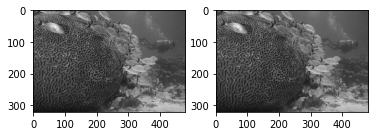

In [ ]:
index = random.randint(0, len(x_train))
img = x_train[index]
ax = plt.subplot(1, 2, 1)
plt.imshow(img.reshape(321,481))
plt.gray()

img = y_train[index]
ax = plt.subplot(1, 2, 2)
plt.imshow(img.reshape(321,481))
plt.gray()

# Training the CNN denoiser

In [ ]:
input_img = keras.Input(shape=(None, None, 1))

x = layers.Conv2D(8, (3, 3), activation="relu", padding='same')(input_img)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)

denoiser = keras.Model(input_img, x)

denoiser.compile(optimizer='adam', loss='binary_crossentropy')

denoiser.fit(x_train, y_train,
                epochs=10,
                batch_size=20,
                shuffle=True,
                validation_data=(x_val, y_val),
                callbacks=[TensorBoard(log_dir='/tmp/denoiser')])

In [ ]:
denoiser.summary()

# Testing the CNN denoiser



Load the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

denoiser = load_model('/content/drive/MyDrive/KABAS-OGUTEN-EE3001-Term-Project/models/denoiser.h5')

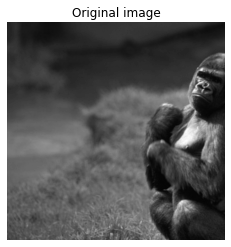

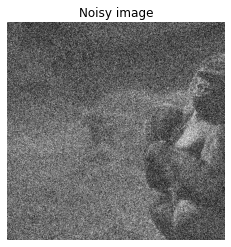

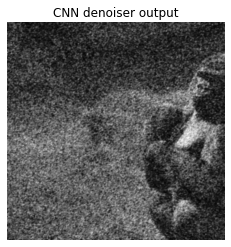

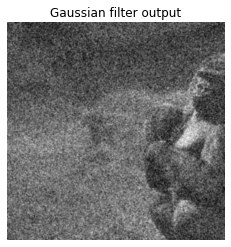

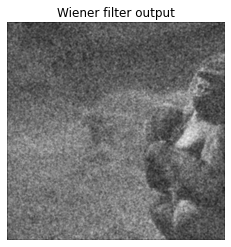

In [ ]:
px = 1000
index = random.randint(0, 39)
img = x_test[index]
img = img.reshape(321,481)

# Crop the image
h_cl = int(img.shape[0]/2)
w_cl = int(img.shape[1]/2)
img = img[h_cl-160:h_cl+160, w_cl-160:w_cl+160]

# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, (px,px))
# img = img.astype('float32') / 255.

# Show original image
plt.imshow(img)
plt.title("Original image")
plt.axis('off')
plt.gray()
plt.show()

# Add noise
noise_factor = 0.7
img = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape)
img = np.clip(img, 0., 1.)

# Show noisy image
plt.imshow(img)
plt.title("Noisy image")
plt.axis('off')
plt.gray()
plt.show()

# Denoising with CNN Denoiser
filtered_cnn = denoiser.predict(img.reshape(1,px,px,1))
filtered_cnn = filtered_cnn.reshape(px,px)

# Gaussian filter
filtered_gaussian = cv2.GaussianBlur(img.reshape(px,px,1),(11,11),0)

# Wiener fiter
filtered_wiener = wiener(img, (8, 8))

# Show filtered images
plt.imshow(filtered_cnn)
plt.title("CNN denoiser output")
plt.axis('off')
plt.gray()
plt.show()

# plt.imshow(filtered_gaussian)
plt.imshow(filtered_gaussian)
plt.title("Gaussian filter output")
plt.axis('off')
plt.gray()
plt.show()

# plt.imshow(filtered_wiener)
plt.imshow(filtered_wiener)
plt.title("Wiener filter output")
plt.axis('off')
plt.gray()
plt.show()